# Restricted Boltzmann Machines on MNIST

In [98]:
# importing relevant libraries
import torch, os, warnings, math
import numpy as np
from torchvision import transforms, utils, datasets
from torch.utils.data import DataLoader, Dataset, sampler, SubsetRandomSampler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

warnings.filterwarnings('ignore')
ROOT_DIR = "/home/nikunjlad"

In [99]:
# checking if cuda is available
train_on_gpu = torch.cuda.is_available()
torch.cuda.set_device(0)
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on Tesla T4 Device {}'.format(str(torch.cuda.current_device())))

CUDA is available!  Training on Tesla T4 Device 0


In [100]:
# get the MNIST data
torch.manual_seed(333)

batch_size = 120     # number of images to be trained at any instance of time in a network
valid_size = 0.2    # 20% data to be kept as validation
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(os.path.join(ROOT_DIR, "data/mnist"), train=True,download=True, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
test_data = datasets.MNIST(os.path.join(ROOT_DIR, "data/mnist"), train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

In [101]:
X_train = train_data.data
y_train = train_data.train_labels
X_test = test_data.data
y_test = test_data.test_labels

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [102]:
class RBM():
    
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible   # number of visible units in RBM
        self.num_hidden = num_hidden    # number of hidden units in RBM
        
        np_rand = np.random.RandomState(1234)
        
        # create a random spread of weights based on a normal distribution
        self.weights = np.asarray(np_rand.uniform(
                                    low=-0.1 * np.sqrt(6. / (num_visible + num_hidden)),
                                    high=0.1 * np.sqrt(6. / (num_visible + num_hidden)),
                                    size=(num_visible, num_hidden)))
        
        # adding bias along axis 0, i.e adding a row of 0's before all the weights
        # this is the bias for hidden neurons
        self.weights = np.insert(self.weights, 0, 0, axis=0)
        
        # adding bias along axis 1, i.e adding a new column before 1st column in the weights
        # this is the bias for the visible neurons
        self.weights = np.insert(self.weights, 0, 0, axis=1)
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def train(self, data, max_epochs = 1000, alpha=0.001, num_samples=64):
        
        
#         print("Number of samples in this batch: ", num_examples)
        # Insert bias units of 1 into the first column.
        
#         print("data shape: ", data.shape)
#         print("weights shape: ", self.weights.shape)
        hidden_v = np.dot(data, self.weights)
#         print("hidden shape: ", hidden_v.shape)
        hidden_probs = self.sigmoid(hidden_v)
#         print("hidden layers probs shape: ", hidden_probs.shape)
        hidden_probs[:, 0] = 1
        rand_shutdown_mat = np.random.rand(num_samples, self.num_hidden+1)
#         print("Random shutdown mat shape: ", rand_shutdown_mat.shape)
        hidden_probs_act = hidden_probs > rand_shutdown_mat
#         print("hidden prob shape: ", hidden_probs_act.shape)
        energy_pos = np.dot(data.T, hidden_probs)
        visible_v = np.dot(hidden_probs_act, self.weights.T)
#         print("Visible shape: ", visible_v.shape)
        visible_probs = self.sigmoid(visible_v)
#         print("Visible probs shape: ", visible_probs.shape)
        visible_probs[:, 0] = 1
        neg_hidden_v = np.dot(visible_probs, self.weights)
        neg_hidden_probs = self.sigmoid(neg_hidden_v)
#         print("negative hidden probs: ", neg_hidden_probs.shape)
        energy_neg = np.dot(visible_probs.T, neg_hidden_probs)
        self.weights += alpha*((energy_pos-energy_neg)/num_samples)
        error = np.sum((data - visible_probs)**2)/num_samples
        return error
    
    def transform(self, input_data):
        input_data = np.insert(input_data, 0, 1, axis = 1)
#         print(input_data.shape)
        outputs = np.dot(input_data, self.weights)
#         print(outputs.shape)
        outputs_activation = self.sigmoid(outputs)
        return outputs_activation

In [120]:
epochs = 150
n_batches = int(len(X_train)/batch_size)
rbm = RBM(num_visible=784, num_hidden=392)

In [121]:
for epoch in range(epochs):
    epoch_loss = 0
    loss = 0
    
    for batch in range(n_batches):
        # reshape data by flattening images and taking a batch of 64 flattened images
        data = np.array(X_train[batch_size*(batch):batch_size*(batch+1)]).reshape(batch_size, -1)
#         print("Flattened data shape: ", data.shape)
        
        # normalize the data by divding each image with its maximum pixel value
        data = data / data.max(axis=1).reshape(data.shape[0],1)
        data = np.insert(data, 0, 1, axis = 1)
        batch_loss = rbm.train(data, alpha=0.15, num_samples=batch_size)
        loss += batch_loss
    epoch_loss += loss / n_batches
    print("Epoch {}: Loss: {}".format(str(epoch+1), str(epoch_loss)))

Epoch 1: Loss: 23.376711880458807
Epoch 2: Loss: 12.064348839097027
Epoch 3: Loss: 9.891197403660632
Epoch 4: Loss: 8.863355697485975
Epoch 5: Loss: 8.2680380259845
Epoch 6: Loss: 7.891626769796642
Epoch 7: Loss: 7.64674367369599
Epoch 8: Loss: 7.460347912972552
Epoch 9: Loss: 7.315897878551272
Epoch 10: Loss: 7.1894889557302
Epoch 11: Loss: 7.105018131165019
Epoch 12: Loss: 7.020779491076433
Epoch 13: Loss: 6.955604870730721
Epoch 14: Loss: 6.899436048952365
Epoch 15: Loss: 6.851660034351294
Epoch 16: Loss: 6.805660704981658
Epoch 17: Loss: 6.761304061725928
Epoch 18: Loss: 6.725362080617757
Epoch 19: Loss: 6.702855313586175
Epoch 20: Loss: 6.664318611088856
Epoch 21: Loss: 6.644223241304156
Epoch 22: Loss: 6.612999768913398
Epoch 23: Loss: 6.594110789598596
Epoch 24: Loss: 6.569132263718832
Epoch 25: Loss: 6.537398366603536
Epoch 26: Loss: 6.5340925481866945
Epoch 27: Loss: 6.510630256598618
Epoch 28: Loss: 6.4850532817746815
Epoch 29: Loss: 6.48021334844424
Epoch 30: Loss: 6.4601033

In [122]:
cluster_data = np.array(X_train[:100].reshape(100, -1))
cluster_data.shape

(100, 784)

In [123]:
output_data = rbm.transform(cluster_data)
output_data.shape

(100, 393)

In [124]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit_transform(output_data)
labels = list(kmeans.labels_)

In [125]:
index_dict = {}
for label in labels:
    index_dict[label] = [i for i, x in enumerate(labels) if x == label]

In [126]:
def print_clusters(label, dict_, y_train):
    labels_ = dict_[label]
    plt.figure(figsize=(20,20))
    k = len(labels_)
    sorted_x = dict(Counter(list(np.array(y_train[labels_]))))
    sorted_x = dict(sorted(sorted_x.items(), key=lambda kv: kv[1], reverse=True))
    labels_1 = ''
    percentage = ''
    j = 1
    for k, v in sorted_x.items():
        labels_1 = labels_1 +'  ' + str(k)
        percentage = percentage + ' '+ str(v*100/sum(sorted_x.values()))[:2] + ' %'
        j = j+1
    for i, idx in enumerate(labels_):
        plt.subplot(k+1, len(labels_), i+1)
        plt.imshow(np.array(X_train[idx]))
    plt.title('Labels  ' + str(labels_1) + '   Percentage   ' + str(percentage))

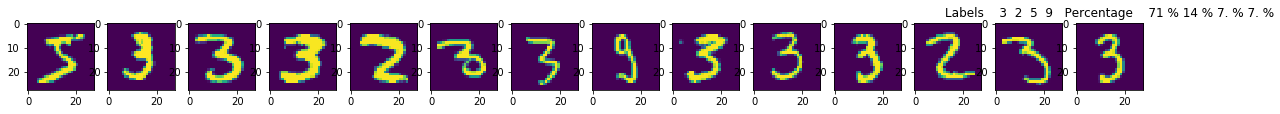

In [127]:
print_clusters(0, index_dict, y_train)

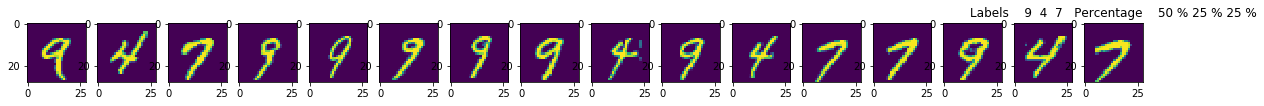

In [128]:
print_clusters(1, index_dict, y_train)

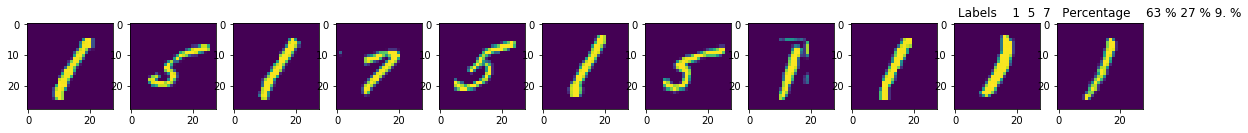

In [129]:
print_clusters(2, index_dict, y_train)

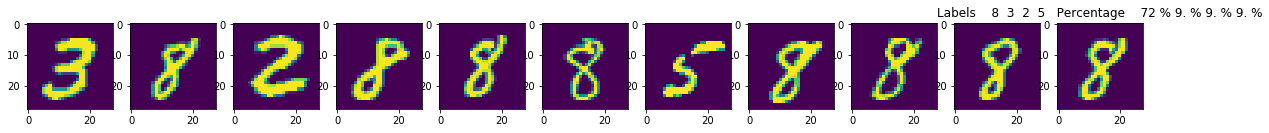

In [130]:
print_clusters(3, index_dict, y_train)

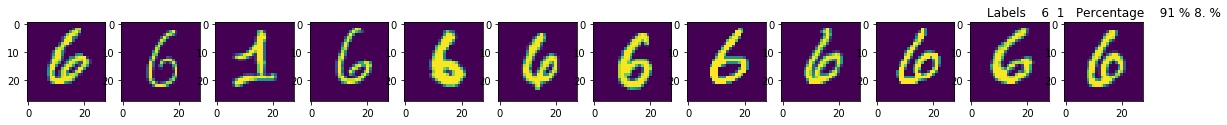

In [131]:
print_clusters(4, index_dict, y_train)

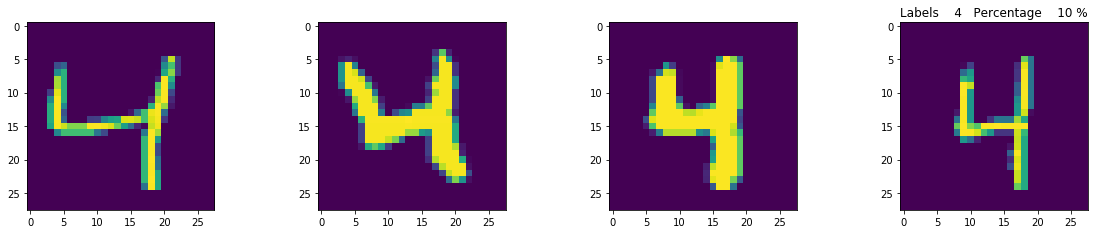

In [132]:
print_clusters(5, index_dict, y_train)

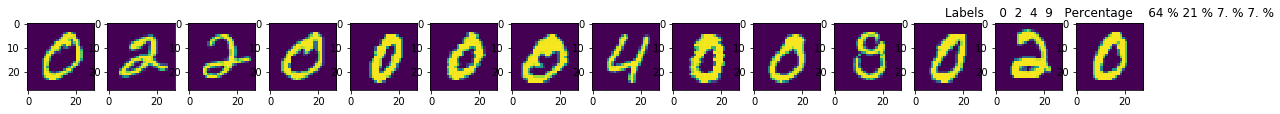

In [133]:
print_clusters(6, index_dict, y_train)

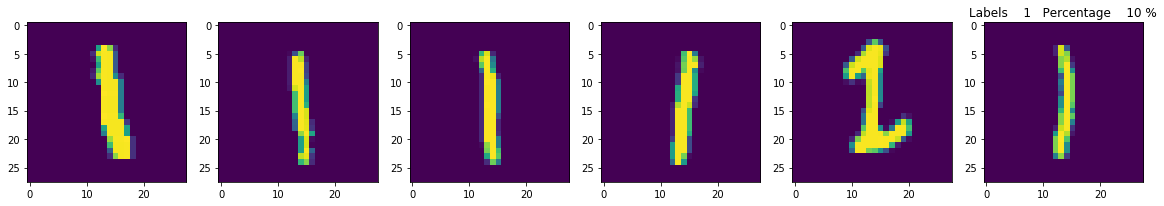

In [134]:
print_clusters(7, index_dict, y_train)

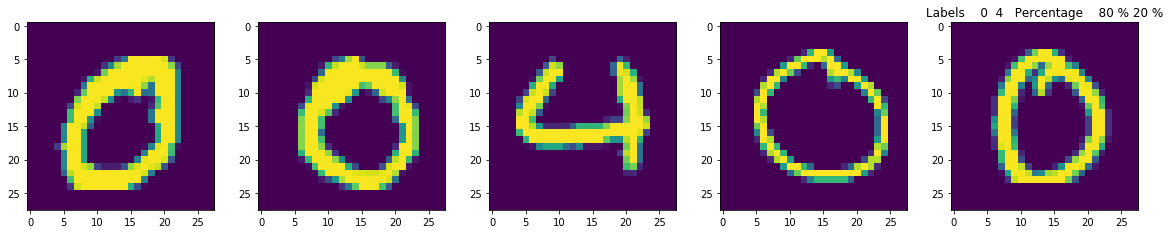

In [135]:
print_clusters(8, index_dict, y_train)

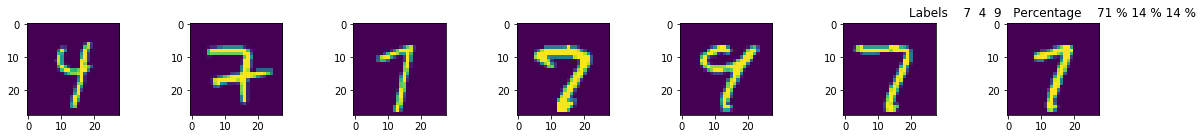

In [136]:
print_clusters(9, index_dict, y_train)